# Substructure Searches in local SQLite Databases
1. Create an example database
1. Connect to the database
1. Enable the SSS extension
1. Perform an example search
1. Display the result in a molgrid

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to silence scikit-learn warnings

import warnings
warnings.filterwarnings('ignore')
warnings.warn = warn

# Type hints
from typing import Iterable, List, Set, Dict, Union, Optional

# Global Imports
# from collections import Counter
# import glob
from pathlib import Path
import sys
import sqlite3

import pandas as pd

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
# from rdkit.Chem import Descriptors as Desc
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
PROJECT_DIR = list(Path("..").absolute().parents)[1]
sys.path.append(str(PROJECT_DIR))
import plt_style       # preferred Matplotlib plotting style
import utils as u      # various utilities for working with Pandas and structures
import mol_view as mv  # display molecules as grids in the Notebook or as separate HTML files (optionally interactive, selection possible)
from utils import lp   # pretty-print various Python objects

## Define a Substructure Search Function
We will use this as an extension for SQLite3 further down.

In [2]:
def sss(smiles, query):
    try:
        m = Chem.MolFromSmiles(smiles)
    except:
        return 0
    if m is None:
        return 0
    q = Chem.MolFromSmiles(query)
        
    if m.HasSubstructMatch(q):
        return 1
    return 0

## Create an Example Database from Pandas DataFrames
### Create Pandas DataFrames from Python dictionaries


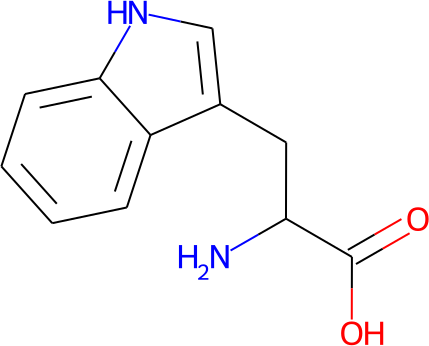
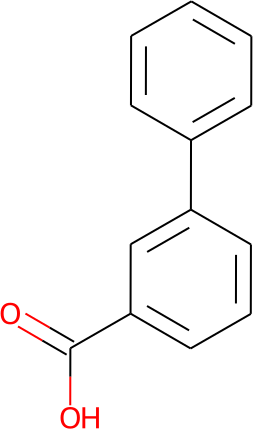
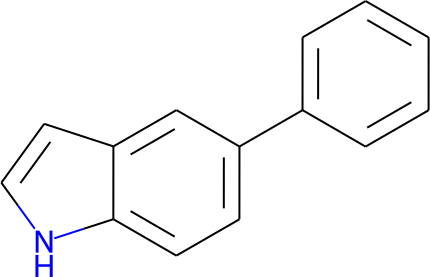
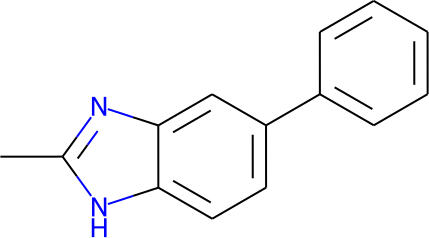

In [3]:
# will become table "Compound" in the database
df1 = pd.DataFrame({
    "Compound_Id": [1, 2, 3, 4],
    "Smiles": ["NC(Cc1c[nH]c2ccccc12)C(=O)O", "O=C(O)c2cccc(c1ccccc1)c2", "c3ccc(c2ccc1[nH]ccc1c2)cc3", "Cc3nc2cc(c1ccccc1)ccc2[nH]3"],
})

# will become table "Batch" in the database
df2 = pd.DataFrame({
    "Compound_Id": [1, 2, 3, 3, 4],
    "Batch_Id": ["1:1", "2:1", "3:1", "3:2", "4:1"]
})

mv.mol_grid(df1)

### Create the Database from the two DataFrames

In [4]:
conn = sqlite3.connect("example.sqlite")

df1.to_sql("Compound", conn, if_exists="replace", index=False)

df2.to_sql("Batch", conn, if_exists="replace", index=False)

conn.commit()
conn.close()
# The database is now permanently written to disk and can be re-used

## Connect (again) to the Database and Enable the SSS Extension from Cell [2]

In [5]:
conn = sqlite3.connect("example.sqlite")
conn.create_function("sss", 2, sss)

## Perform an Example Substructure Search

In [6]:
q = 'c2ccc1[nH]ccc1c2' # indole
df = pd.read_sql(f"""
    select c.Compound_Id, c.Smiles, b.Batch_Id, sss(c.Smiles, '{q}') as Found
    from Compound c, Batch b
    where Found > 0 and c.Compound_Id = b.Compound_Id;""", conn)
lp(df)

Shape                                             :          3 /    4  [ Compound_Id, Smiles, Batch_Id, Found ]  



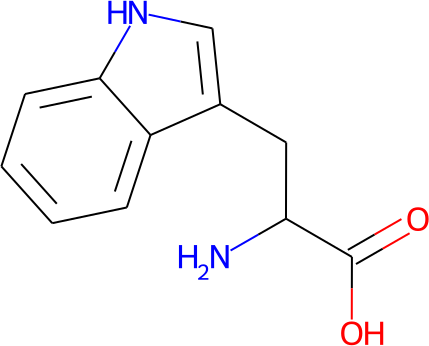
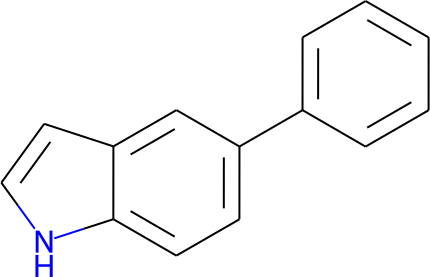
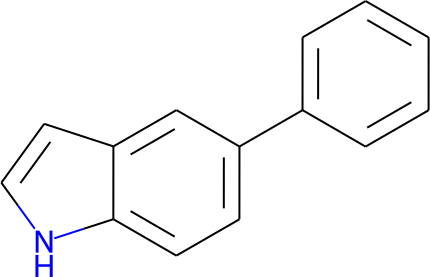

In [7]:
mv.mol_grid(df)